In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import joblib

In [4]:
df = pd.read_csv("Data/steam_reviews.zip", encoding= "ISO-8859-1")
df.head()

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2/10/2019,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,2/10/2019,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,2/7/2019,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns
3,6/14/2018,126,1086,676,False,Recommended,Out of all the reviews I wrote This one is pro...,Dead by Daylight
4,6/20/2017,85,2139,612,False,Recommended,Disclaimer I survivor main. I play games for f...,Dead by Daylight


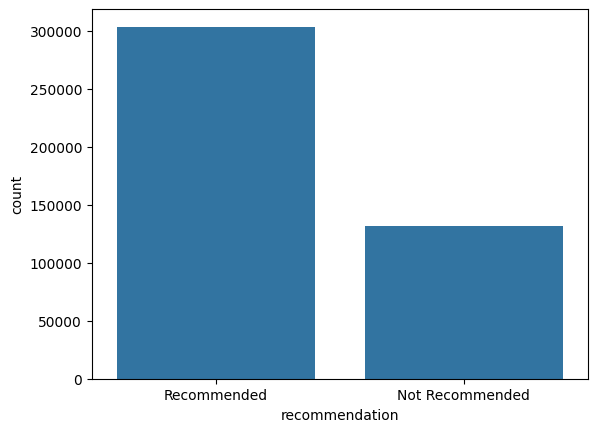

In [5]:
df["recommendation"].value_counts()
sns.countplot(x=df["recommendation"], data=df)
plt.show()

In [6]:
df["sentences"] = df.iloc[:, 6]
df["label"] = df.iloc[:, 5]

In [7]:
df = df[["sentences", "label"]]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434891 entries, 0 to 434890
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentences  433375 non-null  object
 1   label      434891 non-null  object
dtypes: object(2)
memory usage: 6.6+ MB


In [9]:
df.isnull().sum()

sentences    1516
label           0
dtype: int64

In [10]:
df.dropna(subset="sentences", inplace=True)

In [11]:
df.isnull().sum()

sentences    0
label        0
dtype: int64

In [12]:
df['word_count'] = df['sentences'].apply(lambda x: len(x.split()))
df = df[df['word_count'] >= 10].reset_index(drop=True)
df.drop(columns=['word_count'], inplace=True)

In [13]:
df.head()

,sentences,label
0,&gt Played as German Reich&gt Declare war on B...,Recommended
1,Very good game although a bit overpriced in my...,Recommended
2,Out of all the reviews I wrote This one is pro...,Recommended
3,Disclaimer I survivor main. I play games for f...,Recommended
4,ENGLISH After playing for more than two years ...,Recommended


In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["label"] = le.fit_transform(df["label"])
df.head()

,sentences,label
0,&gt Played as German Reich&gt Declare war on B...,1
1,Very good game although a bit overpriced in my...,1
2,Out of all the reviews I wrote This one is pro...,1
3,Disclaimer I survivor main. I play games for f...,1
4,ENGLISH After playing for more than two years ...,1


In [15]:
not_recommended = df[df["label"]==0]
not_recommended.shape

(91171, 2)

In [16]:
recommended = df[df["label"]==1]

balance_recommended = recommended.sample(n=91179, random_state=32)
balance_recommended.shape

(91179, 2)

In [17]:
combined_df = pd.concat([balance_recommended, not_recommended], ignore_index=True)
df = combined_df.sample(frac=1).reset_index(drop=True)
df.shape

(182350, 2)

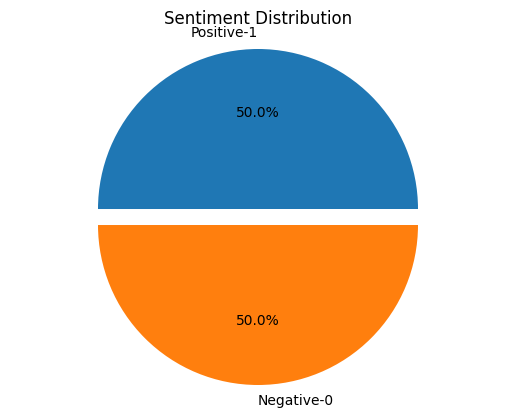

In [18]:
sentiment = ["Positive-1", "Negative-0"]
plt.pie(df["label"].value_counts(), labels=sentiment, explode=(0.1, 0), autopct='%1.1f%%')
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

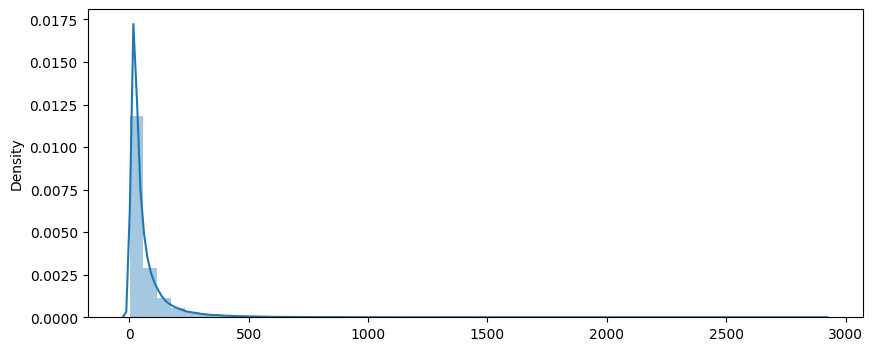

In [19]:
word_count = df['sentences'].apply(lambda x: len(str(x).split(" ")))
plt.figure(figsize=[10, 4])
sns.distplot(x = word_count, kde=True)
plt.show()

In [20]:
import re
import string
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

stopwords = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']



def preprocess(text):
    cleaned_text = re.sub(r"http\S+", "", text)
    cleaned_text = re.sub(r"<[^>]*>", "", cleaned_text)
    cleaned_text = re.sub(r"[^\w\s]", "", cleaned_text)
    cleaned_text = re.sub(r"(.)\1{2,}", r"\1", cleaned_text)
    cleaned_text = re.sub(r"\d", "", cleaned_text)
    cleaned_text = " ".join([word for word in cleaned_text.split() if word.lower() not in stopwords])


    stemmed_words = [ps.stem(word) for word in cleaned_text.split()]
    cleaned_text = " ".join(stemmed_words)

    return cleaned_text

In [21]:
df["sentences"] = df["sentences"].apply(preprocess)
df.head()

,sentences,label
0,great gamea new player mh game hard get but fi...,1
1,permanantli black dude get gangbang gang white...,1
2,hacker game cs year end save time money soulre...,0
3,bit optim peopl averag pc play smooth framer w...,1
4,singleplay great play stori amaz multiplay gre...,1


In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(df["sentences"])
y = df["label"]

In [23]:
joblib.dump(tfidf, "tfidf")

['tfidf']

In [24]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.1, random_state=32)

x_train.shape, x_test.shape

((164115, 192595), (18235, 192595))

### Model Eval

In [112]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
#Evaluation Function

def model_evaluation(model):
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    precision = precision_score(y_test, y_pred)
    print(f"Precision: {precision:.2f}")
    recall = recall_score(y_test, y_pred)
    print(f"Recall: {recall:.2f}")
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.2f}")
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)
    class_report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(class_report)
    return

### Naive Bayes Model

In [113]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(x_train, y_train)

MultinomialNB()

In [114]:
model_evaluation(mnb)

Accuracy: 0.83
Precision: 0.85
Recall: 0.79
F1 Score: 0.82
Confusion Matrix:
[[7865 1231]
 [1940 7199]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      9096
           1       0.85      0.79      0.82      9139

    accuracy                           0.83     18235
   macro avg       0.83      0.83      0.83     18235
weighted avg       0.83      0.83      0.83     18235



### SVM Model

In [ ]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(x_train, y_train)

In [44]:
model_evaluation(svm)

Accuracy: 0.95
Precision: 0.96
Recall: 0.95
F1 Score: 0.95
Confusion Matrix:
[[8702  380]
 [ 482 8672]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      9082
           1       0.96      0.95      0.95      9154

    accuracy                           0.95     18236
   macro avg       0.95      0.95      0.95     18236
weighted avg       0.95      0.95      0.95     18236



### RandomForest Model

In [118]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10)
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=10)

In [120]:
joblib.dump(rf, "rf.joblib")

['rf.joblib']

In [119]:
model_evaluation(rf)

Accuracy: 0.78
Precision: 0.82
Recall: 0.71
F1 Score: 0.76
Confusion Matrix:
[[7636 1460]
 [2626 6513]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79      9096
           1       0.82      0.71      0.76      9139

    accuracy                           0.78     18235
   macro avg       0.78      0.78      0.78     18235
weighted avg       0.78      0.78      0.78     18235



### Xgboost Model

In [82]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [83]:
model_evaluation(xgb)

Accuracy: 0.83
Precision: 0.82
Recall: 0.84
F1 Score: 0.83
Confusion Matrix:
[[7596 1697]
 [1433 7509]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      9293
           1       0.82      0.84      0.83      8942

    accuracy                           0.83     18235
   macro avg       0.83      0.83      0.83     18235
weighted avg       0.83      0.83      0.83     18235



### Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

In [40]:
model_evaluation(dt)

Accuracy: 0.98
Precision: 0.98
Recall: 0.98
F1 Score: 0.98
Confusion Matrix:
[[8856  226]
 [ 225 8929]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      9082
           1       0.98      0.98      0.98      9154

    accuracy                           0.98     18236
   macro avg       0.98      0.98      0.98     18236
weighted avg       0.98      0.98      0.98     18236



### LogisticRegression Model

In [84]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(x_train, y_train)

LogisticRegression()

In [85]:
model_evaluation(lr)

Accuracy: 0.85
Precision: 0.84
Recall: 0.85
F1 Score: 0.85
Confusion Matrix:
[[7864 1429]
 [1353 7589]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      9293
           1       0.84      0.85      0.85      8942

    accuracy                           0.85     18235
   macro avg       0.85      0.85      0.85     18235
weighted avg       0.85      0.85      0.85     18235



In [87]:
test = """
Like being addicted to a class A drug; you know there are cheaters, bugs, and team killers, in most of the matches. But we keep doing it, we keep playing. Because sometimes your team doesn't get instant head-shot by a LMG sniper 500 meters away, and it's alright.It's too late for us, but you have a choice, be free.
"""

In [ ]:
test = preprocess(test)
print(test)
test = tfidf.transform([test])

naive_bayes = mnb.predict(test)
support_vector = svm.predict(test)
random_forest = rf.predict(test)
xgboost_model = xgb.predict(test)
DecisionTree = dt.predict(test)
Logistic = lr.predict(test)

print(f"""NaiveBayes:{naive_bayes},
      XGBoost:{xgboost_model},
      DecisionTree:{DecisionTree},
      SVM:{support_vector},
      RandomForest:{random_forest},
      Logistic Regression:{Logistic}""")

In [39]:
predictions = [naive_bayes, support_vector, random_forest, xgboost_model, DecisionTree, Logistic]
predictions_array = np.array(predictions)
majority_predictions = np.round(np.mean(predictions_array, axis=0)).astype(int)
majority_predictions

array([1])

In [86]:
rf = joblib.load("Models/RandomForestClassifier.joblib")
xgb = joblib.load("Models/XGBClassifier.joblib")
lr = joblib.load("Models/LogisticRegression.joblib")
mnb = joblib.load("Models/MultinomialNB.joblib")
dt = joblib.load("Models/DecisionTreeClassifier.joblib")
svm = joblib.load("Models/SVM.joblib")

In [ ]:
rf.predict()